In [1]:
%matplotlib notebook
#add comments
import os
import sys
import csv
import pickle
from collections import Counter
from datetime import datetime

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit

import torch
from torch import nn
from torch.utils.data import DataLoader
from network import TweetyNet
import librosa
from librosa import display
from microfaune.audio import wav2spc, create_spec, load_wav
from glob import glob

from torch.utils.data import Dataset
from CustomAudioDataset import CustomAudioDataset

from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import scipy
import IPython.display as ipd

from TweetyNetModel import TweetyNetModel  

In [2]:
train = True
fineTuning = False
#needs at least 80 for mel spectrograms ## may be able to do a little less, but must be greater than 60
n_mels=72 # The closest we can get tmeporally is 72 with an output of 432 : i think it depends on whats good
#this number should be proportional to the length of the videos. 
datasets_dir = "/Users/mugetronblue/E4E/AcousticSpecies/passive-acoustic-biodiversity/TweetyNET/data"

In [3]:
def show_mel_spectrogram(spec, uid):
    fig, ax = plt.subplots()
    M_db_bird = librosa.power_to_db(spec, ref=np.max)
    img = librosa.display.specshow(M_db_bird, y_axis='mel', x_axis='time', ax=ax)
    ax.set(title=uid)
    plt.show()

In [4]:
def load_dataset(data_path, use_dump=True):
    mel_dump_file = os.path.join(data_path, "mel_dataset.pkl")
    if os.path.exists(mel_dump_file) and use_dump:
        with open(mel_dump_file, "rb") as f:
            dataset = pickle.load(f)
    else:
        dataset = compute_feature(data_path)
        with open(mel_dump_file, "wb") as f:
            pickle.dump(dataset, f)
    inds = [i for i, x in enumerate(dataset["X"]) if x.shape[1] == 431]
    X = np.array([dataset["X"][i].transpose() for i in inds])
    Y = np.array([int(dataset["Y"][i]) for i in inds])
    uids = [dataset["uids"][i] for i in inds]
    return X, Y, uids

def compute_feature(data_path):
    print(f"Compute features for dataset {os.path.basename(data_path)}")
    labels_file = os.path.join(data_path, "labels.csv")
    print(labels_file)
    if os.path.exists(labels_file):
        with open(labels_file, "r") as f:
            reader = csv.reader(f, delimiter=',')
            labels = {}
            next(reader)  # pass fields names
            for name, _, y in reader:
                labels[name] = y
    else:
        print("Warning: no label file detected.")
        wav_files = glob(os.path.join(data_path, "wav/*.wav"))
        labels = {os.path.basename(f)[:-4]: None for f in wav_files}
    i = 1
    X = []
    Y = []
    uids = []
    for file_id, y in labels.items():
        print(f"{i:04d}/{len(labels)}: {file_id:20s}", end="\r")
        spc = wav2spc(os.path.join(data_path, "wav", f"{file_id}.wav"), n_mels=n_mels)
        X.append(spc)
        Y.append(y)
        uids.append(file_id)
        i += 1
    return {"uids": uids, "X": X, "Y": Y}

def split_dataset(X, Y, test_size=0.2, random_state=0):
    split_generator = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
    ind_train, ind_test = next(split_generator.split(X, Y))
    X_train, X_test = X[ind_train, :, :], X[ind_test, :, :]
    Y_train, Y_test = Y[ind_train], Y[ind_test]
    return ind_train, ind_test

In [5]:
X0, Y0, uids0 = load_dataset(os.path.join(datasets_dir, "ff1010bird_wav"))
X1, Y1, uids1 = load_dataset(os.path.join(datasets_dir, "warblrb10k_public_wav"))
print(X0.shape, X1.shape)
print(Y0.shape, Y1.shape)
print(len(uids0), len(uids1))

X = np.concatenate([X0, X1]).astype(np.float32)/255
Y = np.concatenate([Y0, Y1])
uids = np.concatenate([uids0, uids1])
print(X.shape, Y.shape, uids.shape)
del X0, Y0, uids0, X1, Y1, uids1 

(7690, 431, 72) (445, 431, 72)
(7690,) (445,)
7690 445
(8135, 431, 72) (8135,) (8135,)


In [6]:
Counter(Y)

Counter({0: 5848, 1: 2287})

# Visualization

In [7]:
#should categorize this data

In [24]:
a, sr = librosa.load(os.path.join(datasets_dir, folder_name, "wav", uid+".wav"))
sr

22050

In [73]:
#-100,-2
idx_here = -100
x = X[idx_here]
y = Y[idx_here]
uid = uids[idx_here]
folder_name = "ff1010bird_wav" if "-" not in uid else "warblrb10k_public_wav"
sr = 44100
x.shape

(431, 72)

<IPython.core.display.Javascript object>


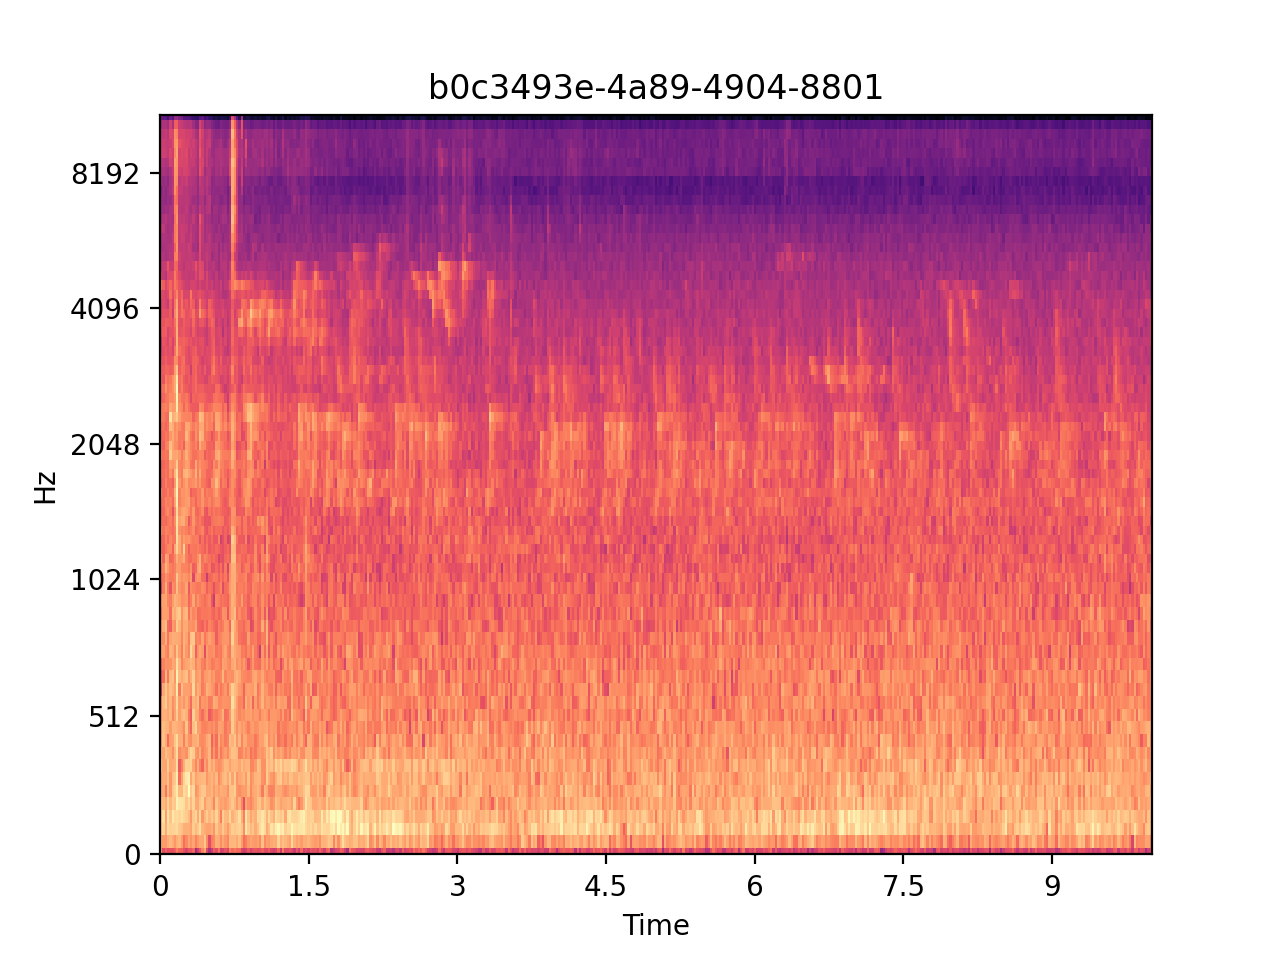

(1, 'b0c3493e-4a89-4904-8801')

In [74]:
show_mel_spectrogram(x.transpose(), uid)
y, uid

In [75]:
ipd.Audio(os.path.join(datasets_dir, folder_name, "wav", uid+".wav"))

<IPython.core.display.Javascript object>


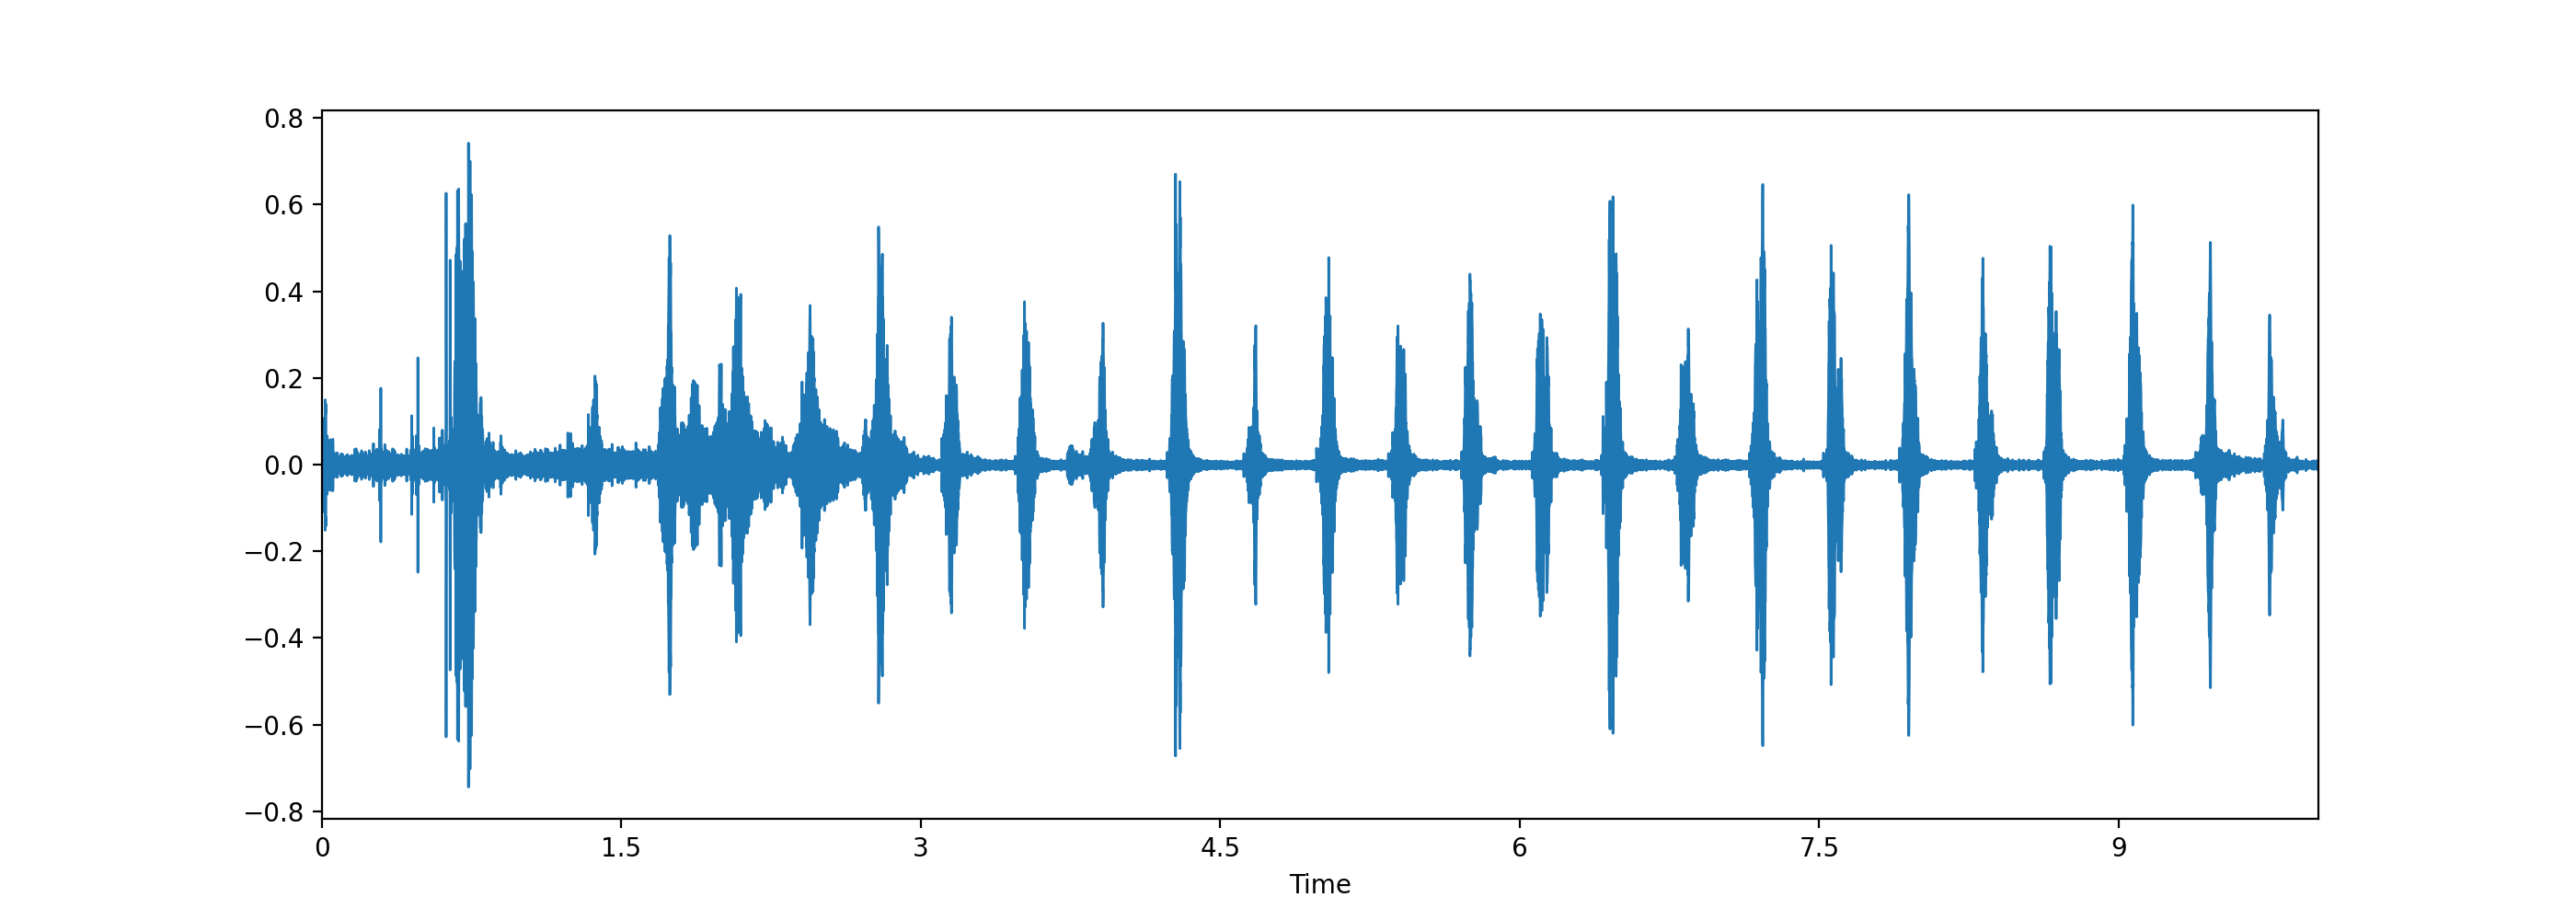

In [15]:
plt.figure(figsize=(14, 5))
librosa.display.waveplot(a, sr=sr)

Actual work

In [13]:
ind_train_val, ind_test = split_dataset(X, Y)
ind_train, ind_val = split_dataset(X[ind_train_val, :, :, np.newaxis], Y[ind_train_val], test_size=0.1)
X_train, X_test, X_val = X[ind_train, :, :, np.newaxis], X[ind_test, :, :, np.newaxis], X[ind_val, :, :, np.newaxis]
Y_train, Y_test, Y_val = Y[ind_train], Y[ind_test], Y[ind_val]
uids_train, uids_test, uids_val = uids[ind_train], uids[ind_test], uids[ind_val]
del X, Y

print("Training set: ", Counter(Y_train))
print("Test set: ", Counter(Y_test))
print("Validation set: ", Counter(Y_val))
#very imbalanced dataset

Training set:  Counter({0: 4391, 1: 1466})
Test set:  Counter({0: 1170, 1: 457})
Validation set:  Counter({0: 476, 1: 175})


In [14]:
len(Counter(Y_train))
X_train[0].shape

(431, 72, 1)

In [15]:
train_dataset = CustomAudioDataset(X_train[:6], Y_train[:6], uids_train[:6])
test_dataset = CustomAudioDataset(X_test[:6], Y_test[:6], uids_test[:6])
val_dataset = CustomAudioDataset(X_val[:6], Y_val[:6], uids_val[:6])

In [16]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))
tweetynet = TweetyNetModel(len(Counter(Y_train)), (1, n_mels, 431), device, binary=True)

Using cpu device


/Users/mugetronblue/opt/anaconda3/envs/species-id/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1623459064158/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [17]:
type(train_dataset[:10])

tuple

Start of epoch: 0
Finished Training
(2592,) torch.Size([2592]) torch.Size([2592])
Finished Testing


<IPython.core.display.Javascript object>


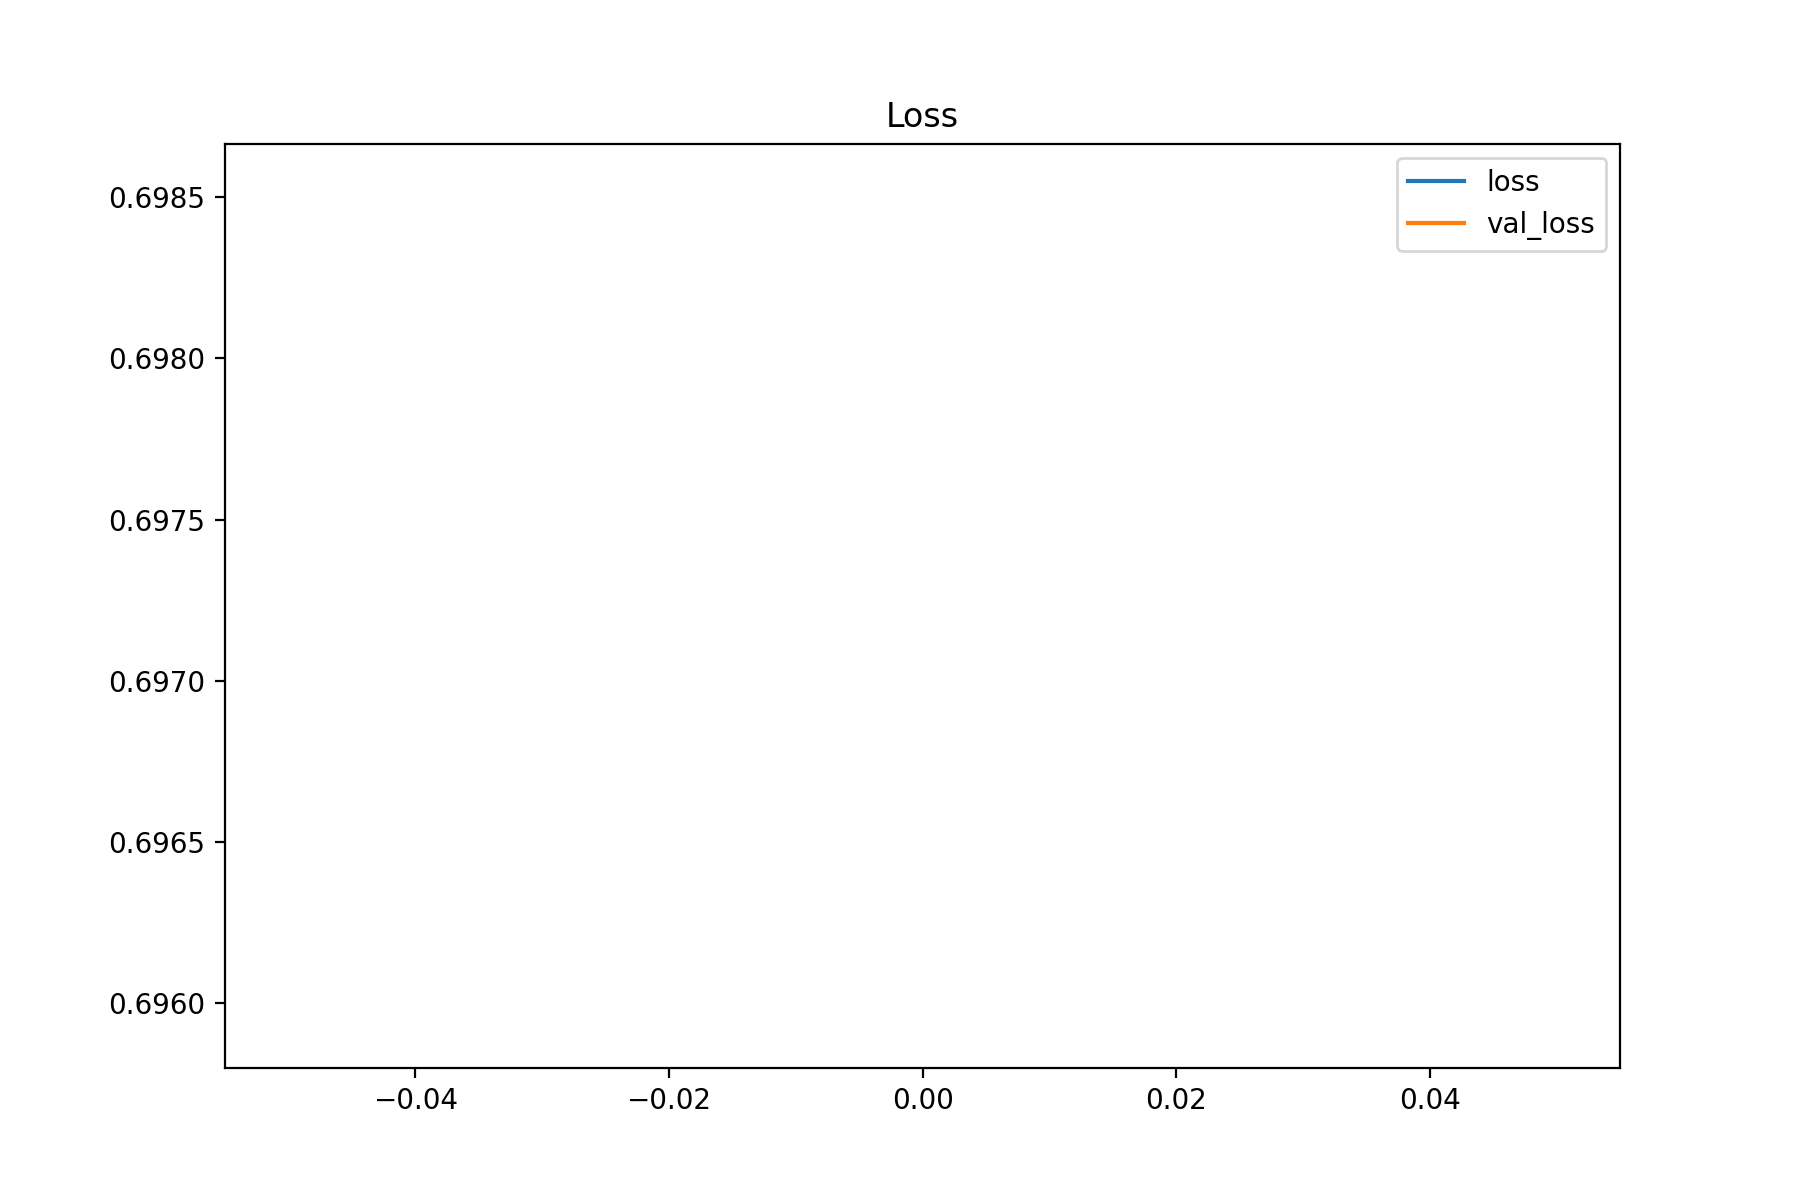

<IPython.core.display.Javascript object>


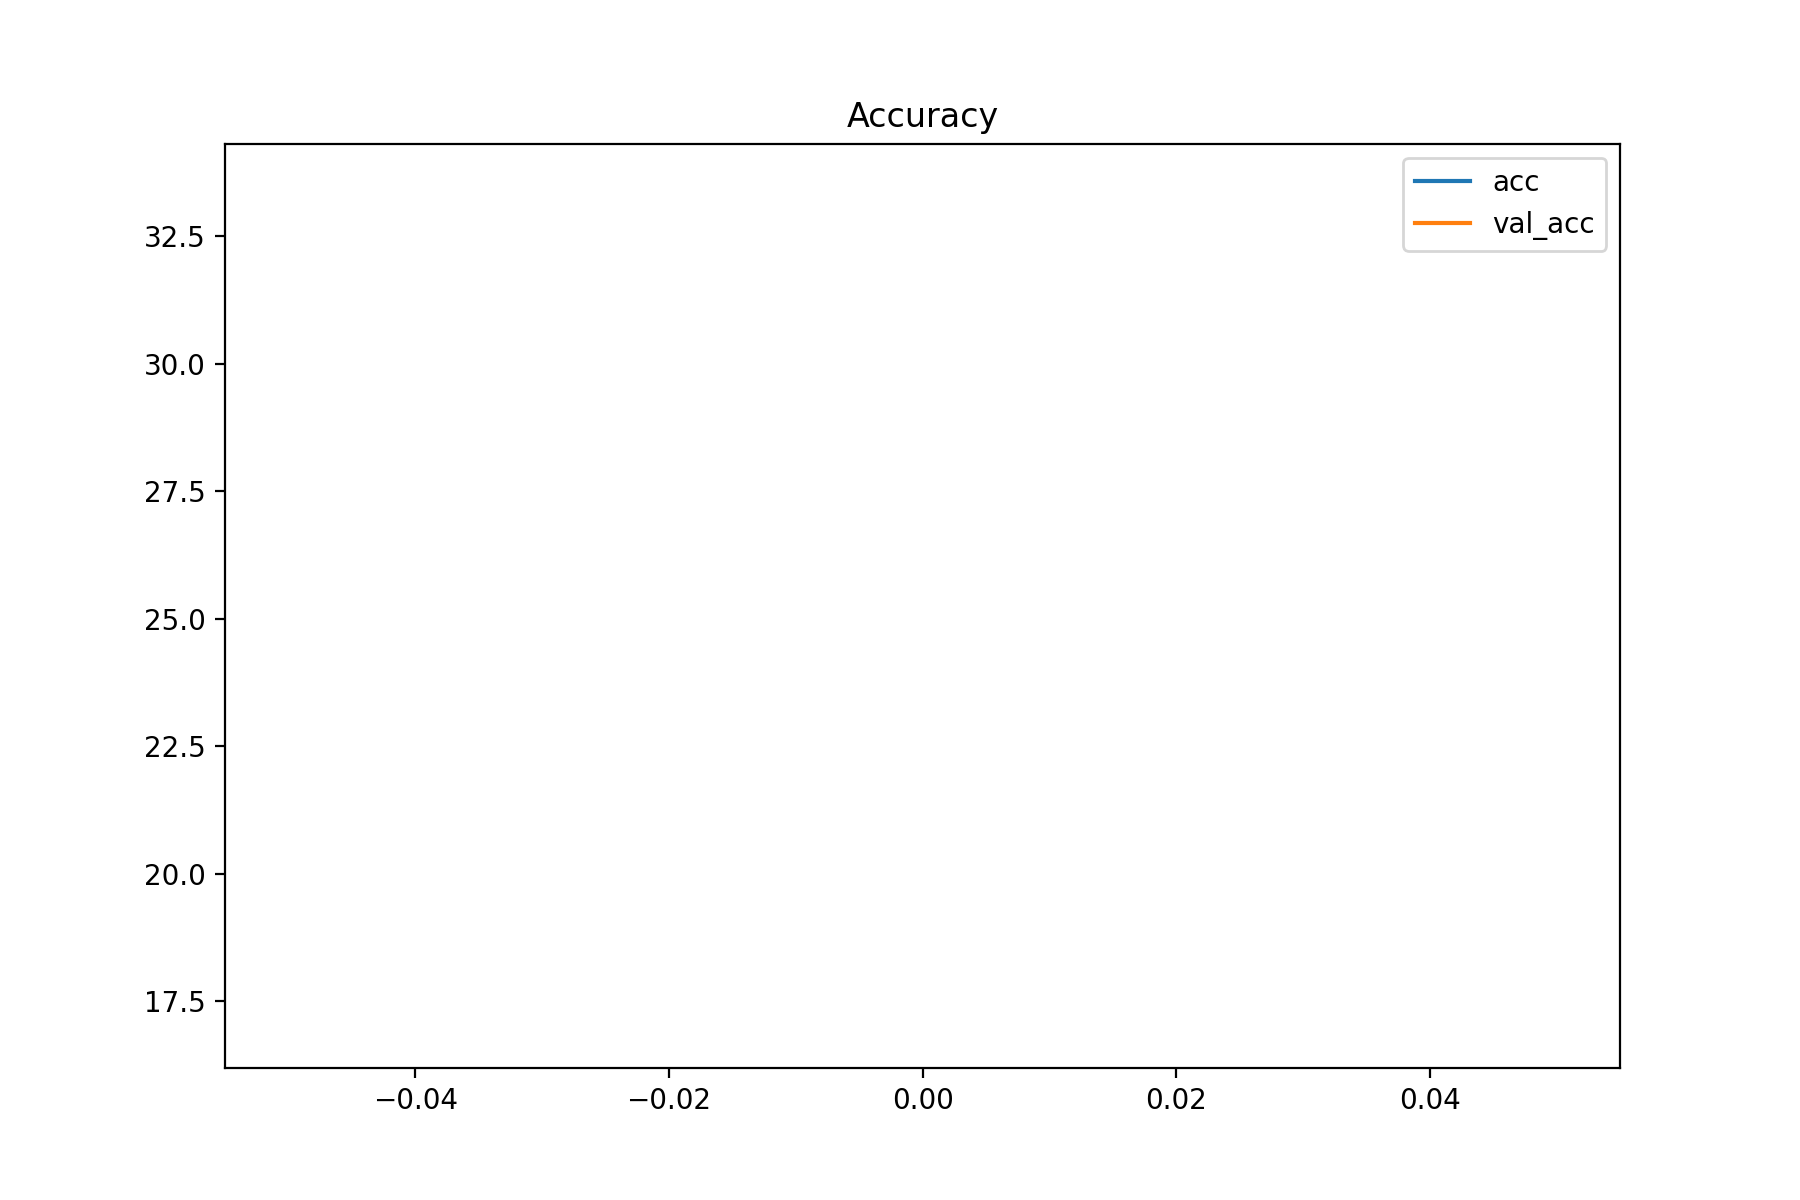

<IPython.core.display.Javascript object>


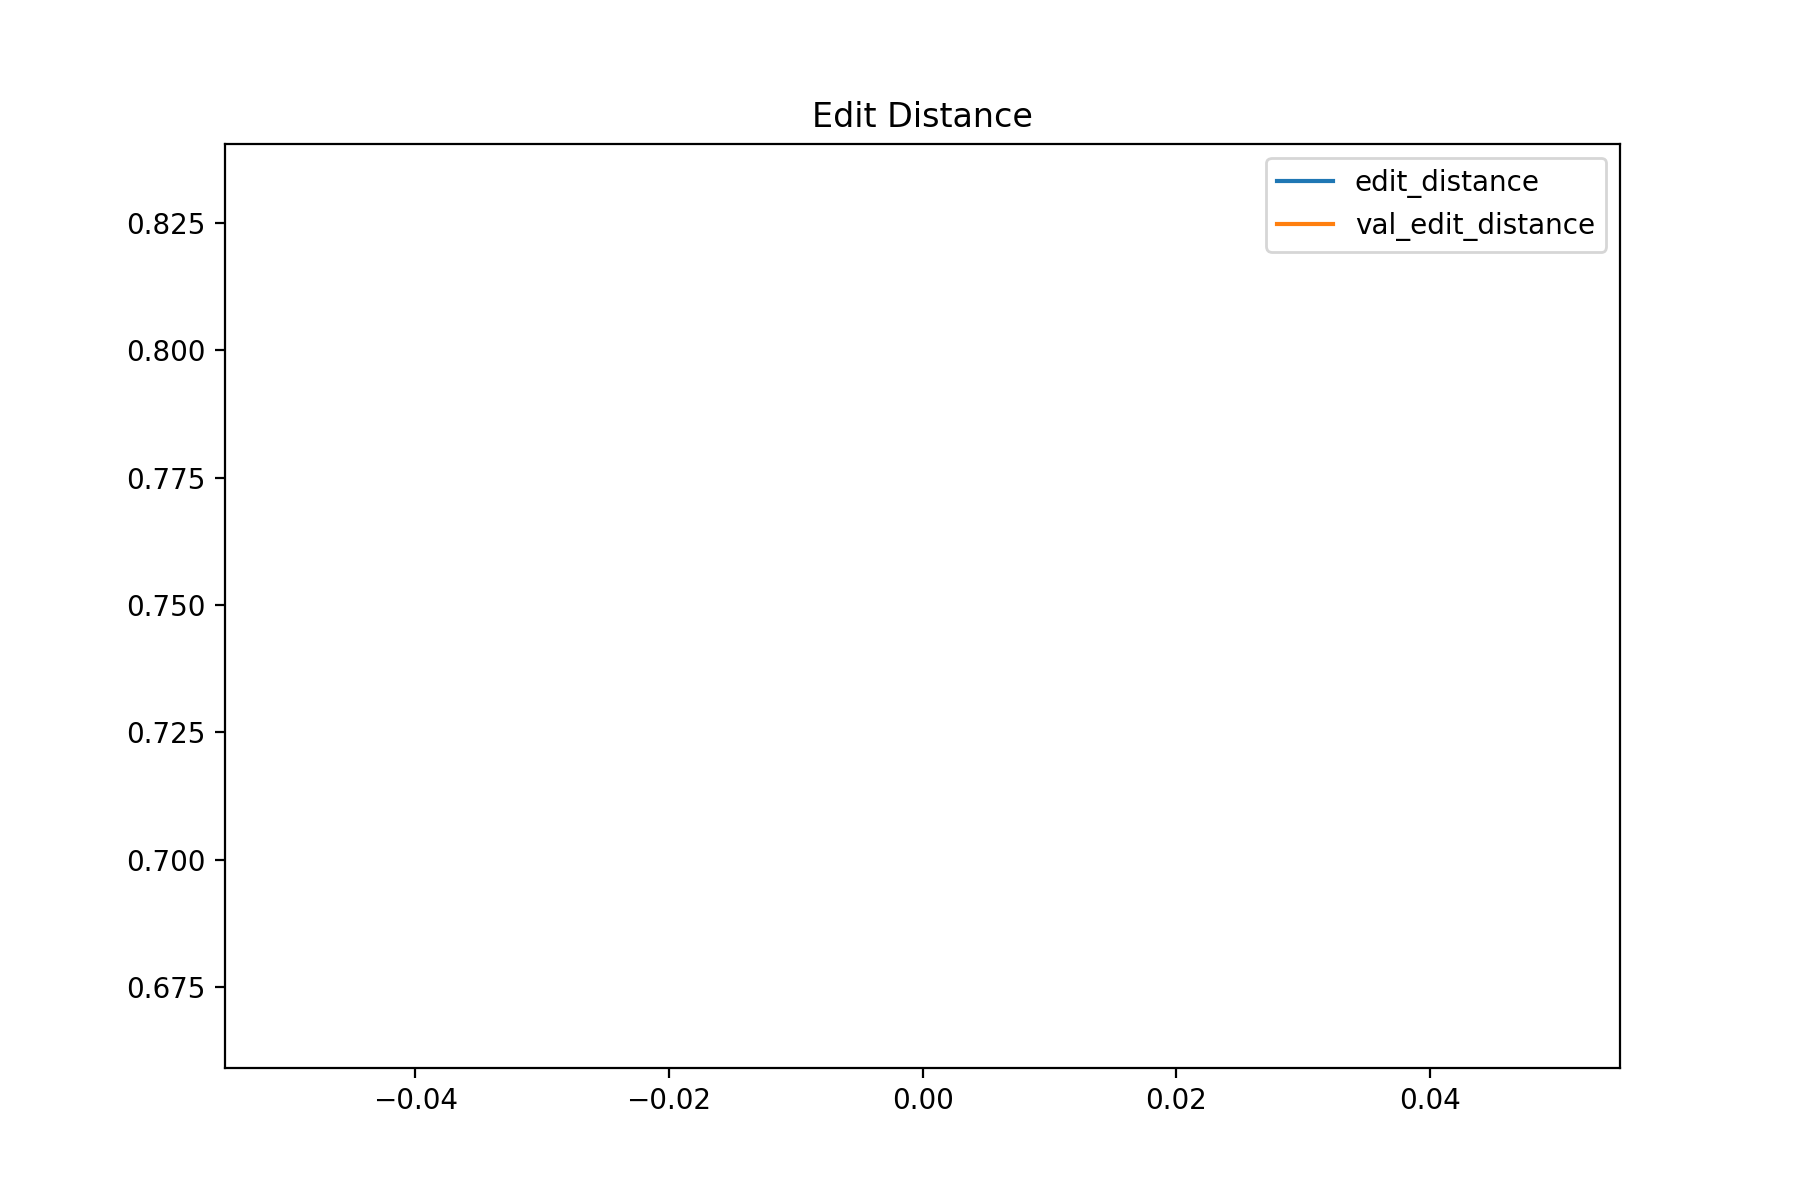

In [18]:
history, test_out, start_time, end_time = tweetynet.train_pipeline(train_dataset, val_dataset, test_dataset, 
                                                                   lr=.001, batch_size=6,epochs=10, save_me=True,
                                                                   fine_tuning=False, finetune_path=None)

In [19]:
end_time - start_time

datetime.timedelta(seconds=8, microseconds=711070)

In [20]:
test_out


,uid,pred,label
0,90359,0,0
1,90359,1,0
2,90359,1,0
3,90359,1,0
4,90359,1,0
...,...,...,...
2587,168791,1,0
2588,168791,1,0
2589,168791,1,0
2590,168791,1,0
